In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import sklearn.decomposition as sk

In [196]:
merged_data = pd.DataFrame(pd.read_pickle('../raw_merged_data_v2'))
merged_data_1985 = pd.DataFrame(pd.read_pickle('../raw_merged_data_v2_withinyears'))
#missing_dropped = merged_data.dropna(axis=1, how='all', ignore_index=True)
#dropped = missing_dropped.drop(['Lifetime risk of maternal death (1 in: rate varies by country)', 'Lifetime risk of maternal death (%)', 'Number of maternal deaths'], axis=1)

### All data

In [197]:
merged_data.shape

(16948, 733)

In [198]:
merged_relevant = merged_data[merged_data['date'] > 1984]
merged_relevant = merged_relevant[merged_relevant['date'] < 2019]
merged_relevant = merged_relevant.drop(columns=['Maternal mortality ratio (modeled estimate, per 100,000 live births)'], axis=1)

In [199]:
merged_features = merged_relevant.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)

In [200]:
merged_features.shape

(9018, 731)

In [201]:
merged_data_peryear_l = (
    merged_features[merged_features['income_num']==1.0].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)
merged_data_peryear_lm = (
    merged_features[merged_features['income_num']==2.0].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)
merged_data_peryear_um = (
    merged_features[merged_features['income_num']==3.0].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)
merged_data_peryear_h = (
    merged_features[merged_features['income_num']==4.0].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)

In [222]:
import seaborn as sns

In [223]:
sns.stripplot(data=merged_data_peryear_l, x='Year', y='PercentMissing', hue='IncomeLevel', jitter=0.25, dodge=True)
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

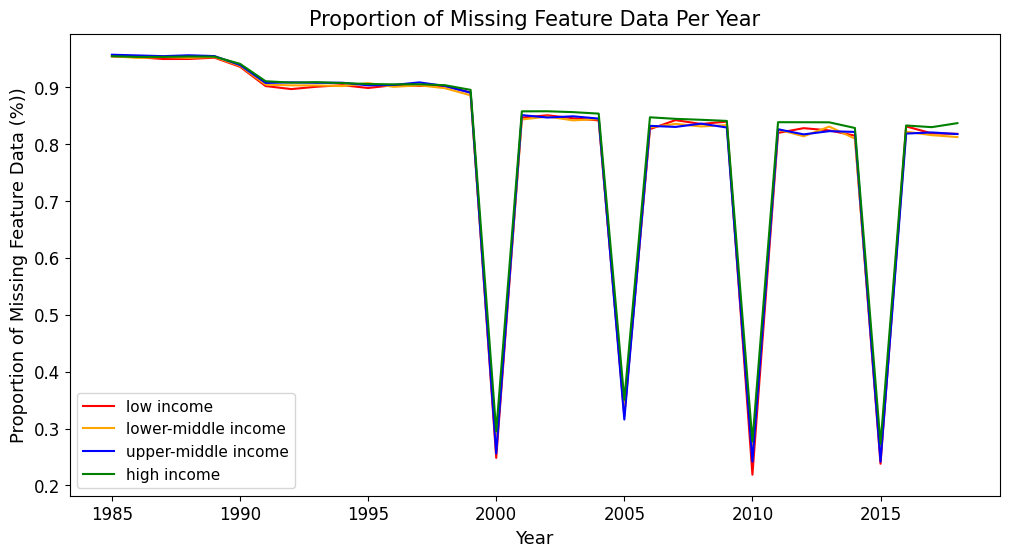

In [225]:
fig = plt.figure(figsize=(12, 6))
plt.plot(merged_data_peryear_l.index, merged_data_peryear_l, label='low income', c='red')
plt.plot(merged_data_peryear_lm.index, merged_data_peryear_lm, label='lower-middle income', c='orange')
plt.plot(merged_data_peryear_um.index, merged_data_peryear_um, label='upper-middle income', c='blue')
plt.plot(merged_data_peryear_h.index, merged_data_peryear_h, label='high income', c='green')
plt.title('Proportion of Missing Feature Data Per Year', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Proportion of Missing Feature Data (%))', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=11)

In [203]:
pd.DataFrame(merged_data_peryear).sort_values(by=0, ascending=True).head(10)

NameError: name 'merged_data_peryear' is not defined

In [ ]:
feature_missing = merged_features.isna().mean()
pd.DataFrame(feature_missing).sort_values(by=0)[160:170]

,0
"Literacy rate, youth total (% of people ages 15-24) female",0.896429
"Prevalence of stunting, height for age (% of children under 5)",0.897427
"Educational attainment, Doctoral or equivalent, population 25+ (%) (cumulative) female",0.900421
"Educational attainment, Doctoral or equivalent, population 25+ (%) (cumulative) male",0.900421
"Literacy rate, youth total (% of people ages 15-24) male",0.903415
"Prevalence of overweight, weight for height (% of children under 5)",0.905855
Trained teachers in preprimary education (% of total teachers) female,0.908073
2.E.06 Other neurological disorders prevalence (age standardized) (per 100 000 population) male,0.913950
2.F.0 Mental disorders prevalence (age standardized) (per 100 000 population) female,0.913950
2.E.07 Headache disorders prevalence (age standardized) (per 100 000 population) male,0.913950


### Correlation Between Features

In [188]:
import pickle
with open('../split_income_models/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../split_income_models/countries_dict.pkl'

In [204]:
without_setting = merged_relevant.copy()
without_setting['setting'] = without_setting['setting'].map(countries_dict)

NameError: name 'countries_dict' is not defined

In [207]:
without_setting = without_setting.dropna(axis=1, how='all', ignore_index=True)
without_setting = without_setting.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])
without_setting = without_setting[without_setting['income_num'] != 0]
features_data = without_setting.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)', 'setting'], axis=1)

In [ ]:
#without_setting = merged_features.drop(columns=['setting'], axis=1)

In [208]:
f_corr = features_data.corr()
upper_tri = f_corr.where(
    ~np.tril(np.ones(f_corr.shape)).astype(bool)
)

# Flatten and drop NaNs
correlation_values = upper_tri.stack().values

Text(0, 0.5, 'Frequency')

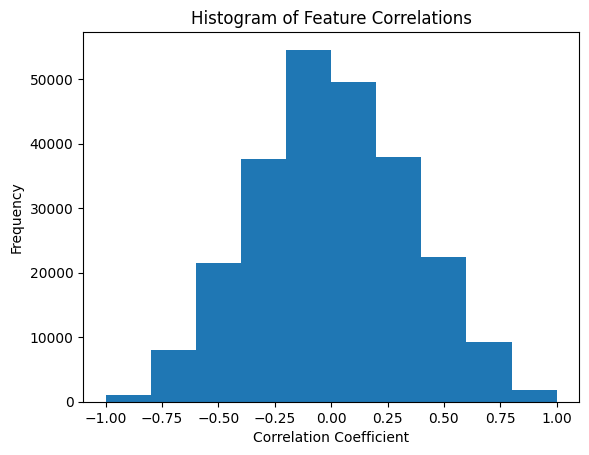

In [209]:
plt.hist(correlation_values)
plt.title('Histogram of Feature Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

In [210]:
high_correlations = upper_tri.stack().reset_index()
high_correlations.columns = ['feature1', 'feature2', 'correlation']
high_correlations = high_correlations[high_correlations['correlation'].abs() > 0.9]
high_correlations.reset_index(drop=True, inplace=True)
high_correlations

,feature1,feature2,correlation
0,date,"Women and girls who use menstrual materials, urban (% of women and girls ages 15-49 living in urban areas who had a menstrual period within the last year)",-0.979144
1,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),Pregnant women receiving prenatal care (%),1.000000
2,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),"Prevalence of underweight, weight for age (% of children under 5)",-1.000000
3,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),Unmet need for contraception (% of married women ages 15-49),1.000000
4,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),"Prevalence of overweight, weight for height, male (% of children under 5)",-1.000000
...,...,...,...
959,Trained teachers in secondary education (% of total teachers) female,Trained teachers in upper secondary education (% of total teachers) male,0.919039
960,Trained teachers in secondary education (% of total teachers) male,Trained teachers in upper secondary education (% of total teachers) female,0.912038
961,Trained teachers in secondary education (% of total teachers) male,Trained teachers in upper secondary education (% of total teachers) male,0.937550
962,Trained teachers in upper secondary education (% of total teachers) female,Trained teachers in upper secondary education (% of total teachers) male,0.957692


In [211]:
964/2

482.0

In [ ]:
missing_data = pd.DataFrame(index = high_correlations.index, columns=['feature1_missing', 'feature2_missing'])
for i, row in high_correlations.iterrows():
    feature1 = row['feature1']
    feature2 = row['feature2']
    missing_data.at[i, 'feature1_missing'] = merged_features[feature1].isna().mean()
    missing_data.at[i, 'feature2_missing'] = merged_features[feature2].isna().mean()
high_correlations = pd.concat([high_correlations, missing_data], axis=1)
high_correlations 

,feature1,feature2,correlation,feature1_missing,feature2_missing
0,Women and girls who use menstrual materials (%...,Women participating in own health care decisio...,0.968715,0.996895,0.98126
1,Women and girls who use menstrual materials (%...,Knowledge of any method of contraception (% of...,1.000000,0.996895,0.973608
2,Women and girls who use menstrual materials (%...,Demand for family planning satisfied by any me...,0.995970,0.996895,0.970725
3,Women and girls who use menstrual materials (%...,Knowledge of any modern method of contraceptio...,1.000000,0.996895,0.973608
4,Women and girls who use menstrual materials (%...,Women participating in none of the three decis...,-0.968308,0.996895,0.981371
...,...,...,...,...,...
579,"Educational attainment, at least Master's or e...","Educational attainment, at least Master's or e...",0.952083,0.893435,0.893435
580,Child employment in agriculture (% of economic...,Child employment in services (% of economicall...,-0.969591,0.983367,0.983367
581,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.980522,0.931249,0.916833
582,Trained teachers in lower secondary education ...,Trained teachers in secondary education (% of ...,0.971133,0.931249,0.916944


In [ ]:
differing_missingness = pd.DataFrame(index = high_correlations.index, columns=['correlation', 'feature1', 'feature1_missing', 'feature2', 'feature2_missing'])
for i, row in high_correlations.iterrows():
    if abs(row['feature1_missing'] - row['feature2_missing']) > 0.2:
        differing_missingness.at[i, 'correlation'] = row['correlation']
        differing_missingness.at[i, 'feature1'] = row['feature1']
        differing_missingness.at[i, 'feature1_missing'] = row['feature1_missing']
        differing_missingness.at[i, 'feature2'] = row['feature2']
        differing_missingness.at[i, 'feature2_missing'] = row['feature2_missing']

differing_missingness = differing_missingness.dropna().reset_index(drop=True)

differing_missingness 


,correlation,feature1,feature1_missing,feature2,feature2_missing
0,-0.978075,"Mortality rate, infant (per 1,000 live births)",0.106676,"Probability of Survival to Age 5, Male",0.944112
1,-0.973634,"Mortality rate, infant (per 1,000 live births)",0.106676,"Probability of Survival to Age 5, Female",0.944112
2,-0.976495,"Mortality rate, infant (per 1,000 live births)",0.106676,Probability of Survival to Age 5,0.944112
3,0.956445,"Survival to age 65, female (% of cohort)",0.000887,"Survival Rate from Age 15-60, Female",0.944666
4,0.976574,"Number of infant deaths, male",0.107563,Number of maternal deaths,0.509093
5,0.993582,"Number of infant deaths, male",0.107563,Number of stillbirths,0.492238
6,-0.983813,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,"Probability of Survival to Age 5, Male",0.944112
7,-0.98225,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,"Probability of Survival to Age 5, Female",0.944112
8,-0.983561,"Mortality rate, under-5, male (per 1,000 live ...",0.106676,Probability of Survival to Age 5,0.944112
9,-0.976975,"Probability of Survival to Age 5, Male",0.944112,"Mortality rate, infant, female (per 1,000 live...",0.106676


In [ ]:
feature_counts = {}

for i, row in differing_missingness.iterrows():
    feature1 = row['feature1']
    feature2 = row['feature2']
    if feature1 not in feature_counts:
        feature_counts[feature1] = 0
    if feature2 not in feature_counts:
        feature_counts[feature2] = 0
    feature_counts[feature1] += 1
    feature_counts[feature2] += 1

feature_counts_df = pd.DataFrame(index = feature_counts.keys(), data=feature_counts.values(), columns=['count']).sort_values(by='count', ascending=False)
feature_counts_df

,count
"Probability of Survival to Age 5, Female",6
Probability of Survival to Age 5,6
"Probability of Survival to Age 5, Male",6
Number of maternal deaths,5
Number of stillbirths,5
"Mortality rate, infant (per 1,000 live births)",3
"Mortality rate, infant, female (per 1,000 live births)",3
"Mortality rate, under-5 (per 1,000 live births)",3
"Mortality rate, infant, male (per 1,000 live births)",3
"Mortality rate, under-5, female (per 1,000 live births)",3


### MMR Correlation

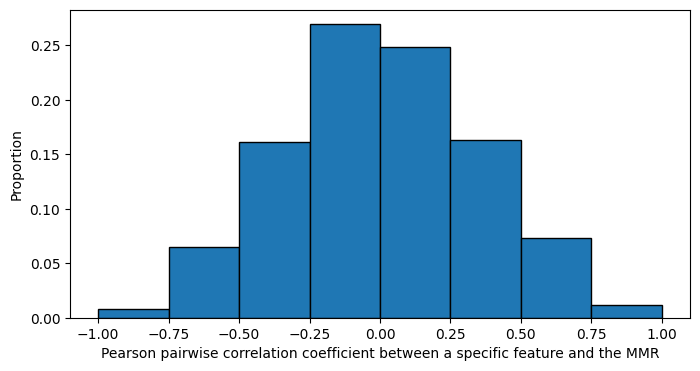

In [227]:
mmr_with_setting = merged_relevant.copy()
mmr_with_setting = mmr_with_setting.dropna(axis=1, how='all', ignore_index=True)
mmr_with_setting = mmr_with_setting.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])
mmr_with_setting = mmr_with_setting[mmr_with_setting['income_num'] != 0]
mmr_with_setting = mmr_with_setting.drop(['setting', 'Lifetime risk of maternal death (1 in: rate varies by country)', 'Lifetime risk of maternal death (%)', 'Number of maternal deaths'], axis=1)

f_corr_mmr = mmr_with_setting.corr()
upper_tri_mmr = f_corr_mmr.where(
    ~np.tril(np.ones(f_corr_mmr.shape)).astype(bool)
)

# Flatten and drop NaNs
correlation_values_mmr = upper_tri_mmr.stack().values
high_correlations_mmr = upper_tri_mmr.stack().reset_index()
high_correlations_mmr.columns = ['feature1', 'feature2', 'correlation']
plt.figure(figsize=(8,4))
#counts, bins, patches = plt.hist(high_correlations_mmr['correlation'], bins=8, weights = [1/len(high_correlations_mmr['correlation'])] * len(high_correlations_mmr['correlation']), edgecolor='black')
plt.hist(high_correlations_mmr['correlation'], bins=8, weights = [1/len(high_correlations_mmr['correlation'])] * len(high_correlations_mmr['correlation']), edgecolor='black')
#plt.bar_label(patches)
plt.xlabel('Pearson pairwise correlation coefficient between a specific feature and the MMR')
plt.ylabel('Proportion')
plt.show()
high_correlations_mmr = high_correlations_mmr[high_correlations_mmr['correlation'].abs() > 0.80]

In [259]:
0.00789399 + 0.0119336

0.01982759

In [224]:
mmr_with_setting[['setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].corr()

,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
setting,1.000000,-0.152381
"Maternal mortality ratio (national estimate, per 100,000 live births)",-0.152381,1.000000


In [228]:
mmr_column = 'Maternal mortality ratio (national estimate, per 100,000 live births)'
mmr_correlations = high_correlations_mmr[
    (high_correlations_mmr['feature1'] == mmr_column) | (high_correlations_mmr['feature2'] == mmr_column)
]
mmr_correlations['absolute_corr'] = mmr_correlations['correlation'].abs()
pd.set_option('display.max_colwidth', None)
sort_mmr_correlation = mmr_correlations.sort_values(by='absolute_corr', ascending=False)
sort_mmr_correlation


/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16748/4202995395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmr_correlations['absolute_corr'] = mmr_correlations['correlation'].abs()


,feature1,feature2,correlation,absolute_corr
783,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),"Maternal mortality ratio (national estimate, per 100,000 live births)",0.995959,0.995959
87455,Probability of Survival to Age 5,"Maternal mortality ratio (national estimate, per 100,000 live births)",-0.869512,0.869512
59601,"Probability of Survival to Age 5, Female","Maternal mortality ratio (national estimate, per 100,000 live births)",-0.867849,0.867849
31512,"Probability of Survival to Age 5, Male","Maternal mortality ratio (national estimate, per 100,000 live births)",-0.867237,0.867237
107915,"Maternal mortality ratio (national estimate, per 100,000 live births)",1.F.01 Maternal disorders prevalence (age standardized) (per 100 000 population) female,0.848715,0.848715
39847,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)","Maternal mortality ratio (national estimate, per 100,000 live births)",0.839796,0.839796
33444,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, male (% of male population)","Maternal mortality ratio (national estimate, per 100,000 live births)",0.839425,0.839425
72698,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, female (% of female population)","Maternal mortality ratio (national estimate, per 100,000 live births)",0.835903,0.835903
107925,"Maternal mortality ratio (national estimate, per 100,000 live births)",1.G.03 Vitamin A deficiency prevalence (age standardized) (per 100 000 population) male,0.826809,0.826809
50447,"Cause of death, by non-communicable diseases, female (% of female population)","Maternal mortality ratio (national estimate, per 100,000 live births)",-0.825651,0.825651


In [214]:
useful_features = ['Women participating in own health care decisions (% of women age 15-49)',
                   'Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year)',
                   'Mortality rate, infant (per 1,000 live births)', 'Female genital mutilation prevalence (%)',
                   'Pregnant women receiving prenatal care (%)', 'Knowledge of any method of contraception (% of all women ages 15-49)',
                   'Demand for family planning satisfied by any methods (% of married women with demand for family planning)',
                   'Unmet need for contraception (% of married women ages 15-49)', 'Pregnant women receiving prenatal care of at least four visits (% of pregnant women)',
                   'Decision maker about a woman\'s own health care: someone else (% of women age 15-49)',
                    "Women\'s share of population ages 15+ living with HIV (%)", 
                    'Teenage mothers (% of women ages 15-19 who have had children or are currently pregnant)', "Births attended by skilled health staff (% of total)",
                    "Prevalence of overweight (% of adults)", "Survival to age 65, female (% of cohort)", 
                    "Stillbirth rate (per 1,000 total births)", "Prevalence of anemia among pregnant women (%)",
                    "Fertility rate, total (births per woman)", 
                    "Women with high empowerment in the attitude to violence domain (%) Quintile 1 (poorest)",
                    "1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female",
                    "1.D.0 Neglected tropical diseases and malaria prevalence (age standardized) (per 100 000 population) female",
                    "1.F.0 Maternal and neonatal disorders prevalence (age standardized) (per 100 000 population) female",
                    "1.G.0 Nutritional deficiencies prevalence (age standardized) (per 100 000 population) female",
                    "2.0.0 Non-communicable diseases prevalence (age standardized) (per 100 000 population) female",
                    "2.G.0 Substance use disorders prevalence (age standardized) (per 100 000 population) female",
                    "3.B.06 Adverse effects of medical treatment prevalence (age standardized) (per 100 000 population) female",
                    "3.C.0 Self-harm and interpersonal violence prevalence (age standardized) (per 100 000 population) female",
                    "3.B.10 Exposure to forces of nature prevalence (age standardized) (per 100 000 population) female",
                    "3.C.04 Conflict and terrorism prevalence (age standardized) (per 100 000 population) female",
                    "School enrollment, secondary (% net) female", "Literacy rate, adult total (% of people ages 15 and above) female",
                    "income_num", "Borrowed for health or medical purposes (% age 15+)",
                    "2.B.04 Hypertensive heart disease prevalence (age standardized) (per 100 000 population) female",
                    "2.H.0 Diabetes and kidney diseases prevalence (age standardized) (per 100 000 population) female",
                    "Probability of Survival to Age 5",
                    "Population living in areas where elevation is below 5 meters (% of total population) rural",
                    "Coverage of social safety net programs (% of population) Quintile 1 (poorest)"
                   ]

In [218]:
count = 0
for uf in useful_features:
    if (uf == sort_mmr_correlation['feature1']).any() or (uf == sort_mmr_correlation['feature2']).any():
        print(uf)
        count += 1
print(count)

Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year)
Mortality rate, infant (per 1,000 live births)
Demand for family planning satisfied by any methods (% of married women with demand for family planning)
Pregnant women receiving prenatal care of at least four visits (% of pregnant women)
Births attended by skilled health staff (% of total)
Survival to age 65, female (% of cohort)
Stillbirth rate (per 1,000 total births)
Fertility rate, total (births per woman)
1.D.0 Neglected tropical diseases and malaria prevalence (age standardized) (per 100 000 population) female
1.F.0 Maternal and neonatal disorders prevalence (age standardized) (per 100 000 population) female
School enrollment, secondary (% net) female
Literacy rate, adult total (% of people ages 15 and above) female
Probability of Survival to Age 5
13


### Saving Features with High Correlation

In [112]:
corr_60 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_60.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_60.add(row['feature2'])

In [116]:
corr_70 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_70.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_70.add(row['feature2'])

In [120]:
corr_80 = set()
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_80.add(row['feature1'])
    if row['feature2'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        corr_80.add(row['feature2'])

In [121]:
len(corr_60), len(corr_70), len(corr_80)

(113, 45, 11)

In [122]:
with open('../feature_selection_models/corr_60.pkl', 'wb') as f:
    pickle.dump(corr_60, f)

with open('../feature_selection_models/corr_70.pkl', 'wb') as f:
    pickle.dump(corr_70, f)

with open('../feature_selection_models/corr_80.pkl', 'wb') as f:
    pickle.dump(corr_80, f)

In [123]:
for index, row in mmr_correlations.iterrows():
    if row['feature1'] != 'Maternal mortality ratio (national estimate, per 100,000 live births)':
        print(row['feature1'])
    else: print(row['feature2'])
    print(row['correlation'])
    print("*****************")
    break

Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year)
0.9959587197839146
*****************


In [173]:
a = pd.DataFrame([[5, 9, 4, 'NaN'], [10, 'NaN', 'NaN', 10], [7, 12, 11, 'NaN']])
a.corr()

,0,1,2,3
0,1.0,1.0,1.0,NaN
1,1.0,1.0,1.0,NaN
2,1.0,1.0,1.0,NaN
3,NaN,NaN,NaN,NaN


### MMR Trends

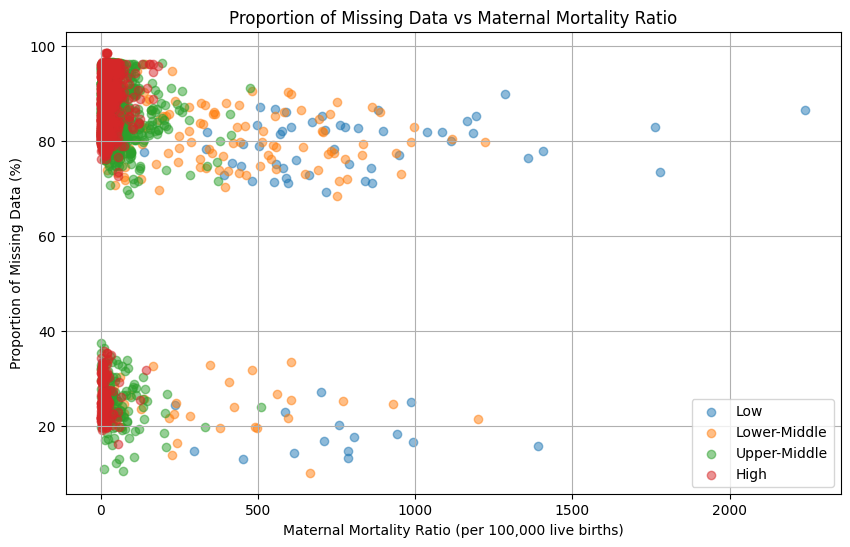

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_relevant[merged_relevant['income_num'] == 1.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], merged_relevant[merged_relevant['income_num'] == 1.0].isna().mean(axis=1) * 100, alpha=0.5, label='Low')
plt.scatter(merged_relevant[merged_relevant['income_num'] == 2.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], merged_relevant[merged_relevant['income_num'] == 2.0].isna().mean(axis=1) * 100, alpha=0.5, label='Lower-Middle')
plt.scatter(merged_relevant[merged_relevant['income_num'] == 3.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], merged_relevant[merged_relevant['income_num'] == 3.0].isna().mean(axis=1) * 100, alpha=0.5, label='Upper-Middle')
plt.scatter(merged_relevant[merged_relevant['income_num'] == 4.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], merged_relevant[merged_relevant['income_num'] == 4.0].isna().mean(axis=1) * 100, alpha=0.5, label='High')
plt.title('Proportion of Missing Data vs Maternal Mortality Ratio')
plt.xlabel('Maternal Mortality Ratio (per 100,000 live births)')
plt.ylabel('Proportion of Missing Data (%)')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
missing_mmr_df_l = (
    merged_relevant[merged_relevant['income_num']==1.0][['date', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)

missing_mmr_df_lm = (
    merged_relevant[merged_relevant['income_num']==2.0][['date', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)
missing_mmr_df_um = (
    merged_relevant[merged_relevant['income_num']==3.0][['date', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)
missing_mmr_df_h = (
    merged_relevant[merged_relevant['income_num']==4.0][['date', 'Maternal mortality ratio (national estimate, per 100,000 live births)']].groupby(['date'])
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * x.shape[1]))
    .drop(columns='date', errors='ignore')  # Drop 'year' column if present
)

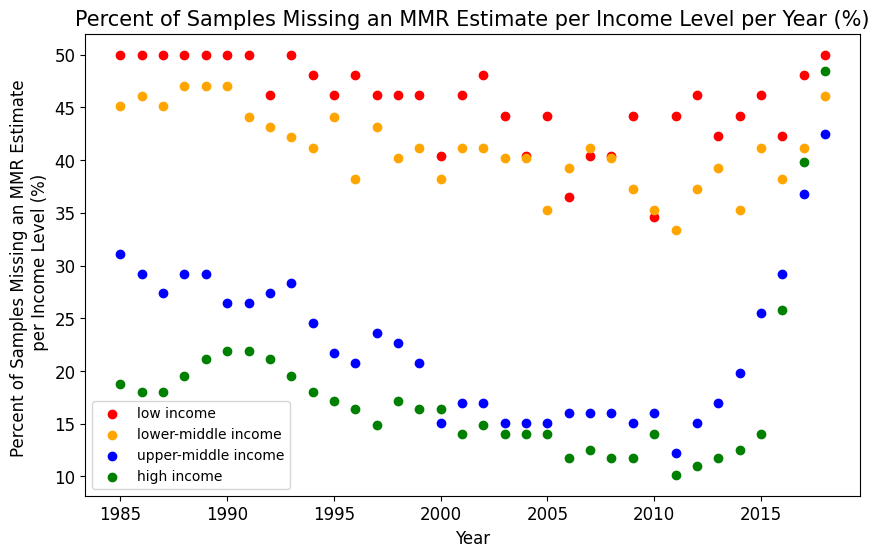

In [155]:
fig = plt.figure(figsize=(10, 6))
 
plt.scatter(missing_mmr_df_l.index, missing_mmr_df_l * 100, label='low income', c='red')
plt.scatter(missing_mmr_df_lm.index, missing_mmr_df_lm * 100, label='lower-middle income', c='orange')
plt.scatter(missing_mmr_df_um.index, missing_mmr_df_um * 100, label='upper-middle income', c='blue')
plt.scatter(missing_mmr_df_h.index, missing_mmr_df_h * 100, label='high income', c='green')
plt.xlabel('Year', fontsize=12)
plt.title('Percent of Samples Missing an MMR Estimate per Income Level per Year (%)', fontsize=15)
plt.ylabel('Percent of Samples Missing an MMR Estimate \n per Income Level (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

In [40]:
missing_mmr_df_um.tail(10)

date
2009.0    0.150943
2010.0    0.160377
2011.0    0.122642
2012.0    0.150943
2013.0    0.169811
2014.0    0.198113
2015.0    0.254717
2016.0    0.292453
2017.0    0.367925
2018.0    0.424528
dtype: float64

In [65]:
mr_plotting = merged_relevant[['date', 'income_num', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]

In [66]:
mr_df = pd.DataFrame({
    'median' : mr_plotting.groupby(['date', 'income_num'])['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(),
    'mean' : mr_plotting.groupby(['date', 'income_num'])['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean()
})

In [129]:
median_mmrl = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 1.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].median())
median_mmrl.columns = ['Median']
median_mmrl = median_mmrl.reset_index()
median_mmrlm = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 2.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].median())
median_mmrlm.columns = ['Median']
median_mmrlm = median_mmrlm.reset_index()
median_mmrum = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 3.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].median())
median_mmrum.columns = ['Median']
median_mmrum = median_mmrum.reset_index()
median_mmrh = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 4.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].median())
median_mmrh.columns = ['Median']
median_mmrh = median_mmrh.reset_index()

In [83]:
mean_mmrl = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 1.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean())
mean_mmrl.columns = ['Mean']
mean_mmrl = mean_mmrl.reset_index()
mean_mmrlm = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 2.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean())
mean_mmrlm.columns = ['Mean']
mean_mmrum = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 3.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean())
mean_mmrum.columns = ['Mean']
mean_mmrh = pd.DataFrame(mr_plotting[mr_plotting['income_num'] == 4.0].groupby((['date']))['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean())
mean_mmrh.columns = ['Mean']

In [86]:
mmrl = pd.merge(median_mmrl, mean_mmrl, on=['date'])

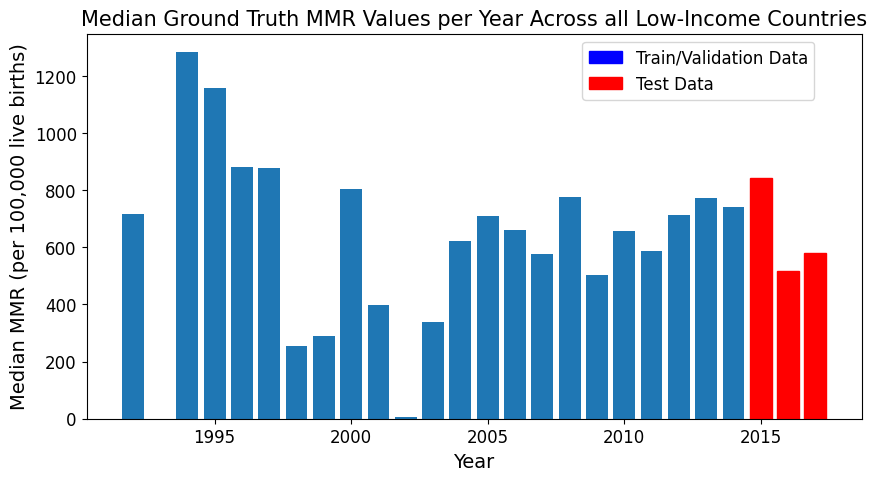

In [151]:
import matplotlib.patches as mpatches  # For custom legend handles

plt.figure(figsize=(10, 5))
plt.title('Median Ground Truth MMR Values per Year Across all Low-Income Countries', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Median MMR (per 100,000 live births)', fontsize=14)
bars_median = plt.bar(median_mmrl['date'], median_mmrl['Median'], label = 'Median')
#plt.bar(mean_mmrl.index, median_mmrl['Mean'], label = 'Mean')
#bars_median = plt.bar(median_mmrlm['date'], median_mmrlm['Median'], label = 'Lower-Middle')
#bars_median = plt.bar(median_mmrum['date'], median_mmrum['Median'], label = 'Upper-Middle')
#bars_median = plt.bar(median_mmrh['date'], median_mmrh['Median'], label = 'High')
#plt.legend()

for i, year in enumerate(median_mmrl['date']):
    if 2015 <= year <= 2018:
        bars_median[i].set_color('red')  

tv_patch = mpatches.Patch(color='blue', label='Train/Validation Data')
test_patch = mpatches.Patch(color='red', label='Test Data')
plt.legend(handles=[tv_patch, test_patch], loc='upper right', bbox_to_anchor=(0.95, 1), fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

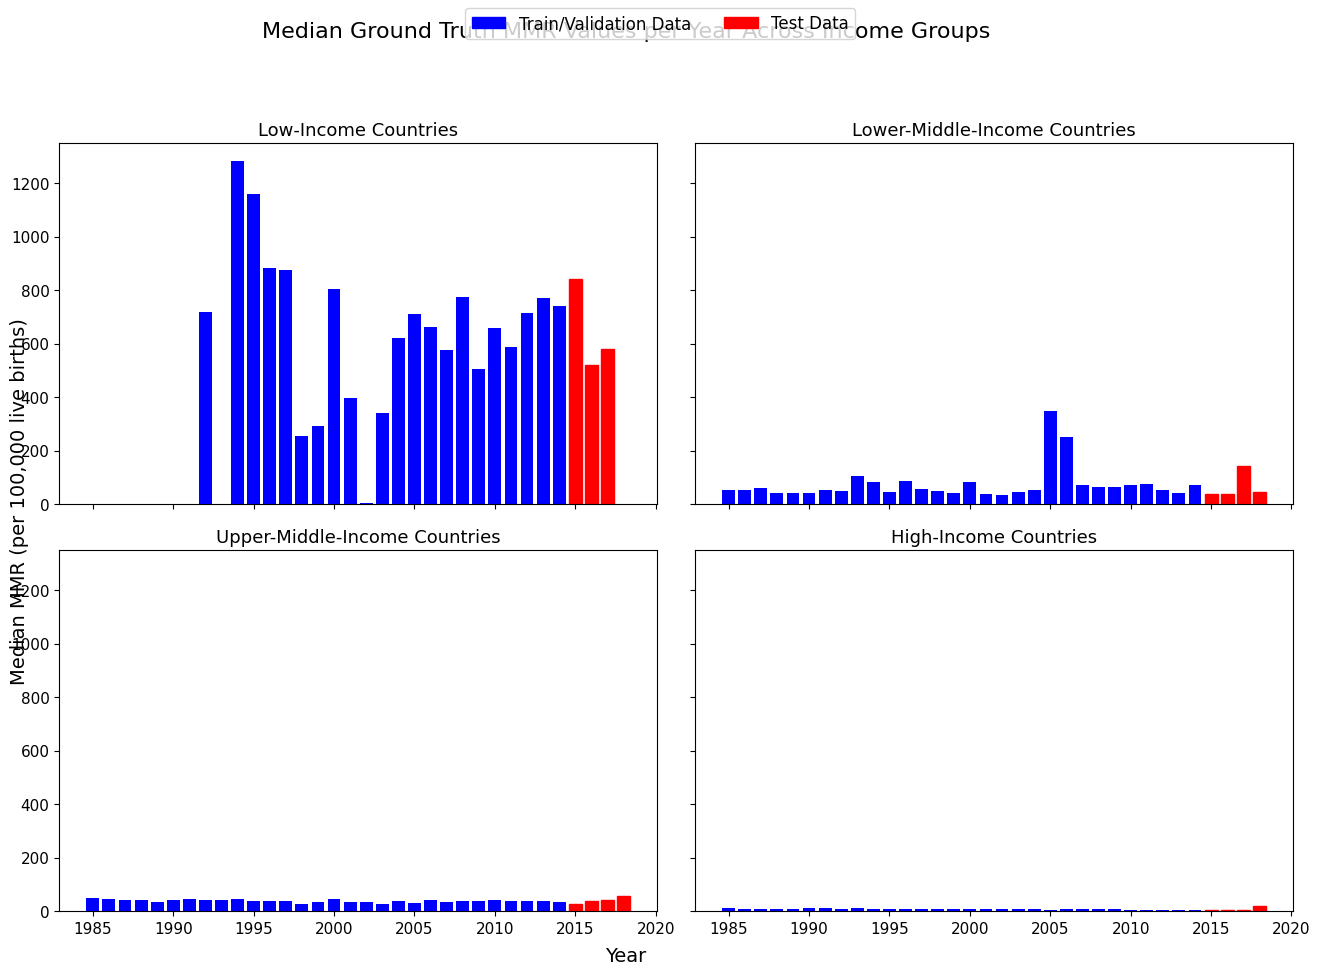

In [156]:
# Define the datasets and titles
datasets = [median_mmrl, median_mmrlm, median_mmrum, median_mmrh]
titles = ['Low-Income Countries', 'Lower-Middle-Income Countries', 
          'Upper-Middle-Income Countries', 'High-Income Countries']

# Create a 2x2 grid of subplots with shared x and y axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Define colors
train_color = 'blue'
test_color = 'red'

# Loop through each subplot
for i, ax in enumerate(axes):
    df = datasets[i]
    bars = ax.bar(df['date'], df['Median'], color=train_color)

    # Highlight test years in red
    for j, year in enumerate(df['date']):
        if 2015 <= year <= 2018:
            bars[j].set_color(test_color)

    # Set subplot title
    ax.set_title(titles[i], fontsize=13)
    ax.tick_params(axis='both', labelsize=11)

# Shared x/y axis labels
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.06, 0.5, 'Median MMR (per 100,000 live births)', va='center', rotation='vertical', fontsize=14)

# Shared legend
tv_patch = mpatches.Patch(color=train_color, label='Train/Validation Data')
test_patch = mpatches.Patch(color=test_color, label='Test Data')
fig.legend(handles=[tv_patch, test_patch], loc='upper center', ncol=2, fontsize=12)

# Shared super-title
fig.suptitle('Median Ground Truth MMR Values per Year Across Income Groups', fontsize=16)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.93])  # Leave space for shared title
plt.show()

##### High Income Exploration

In [143]:
high_2015 = pd.DataFrame(merged_relevant[(merged_relevant['income_num'] == 4.0) & (merged_relevant['date'] == 2015) & (merged_relevant['Maternal mortality ratio (national estimate, per 100,000 live births)'].notna())])
high_2015[['date', 'setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]

,date,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
6720,2015.0,Australia,3.0
6784,2015.0,Austria,5.0
7168,2015.0,Belgium,3.0
7680,2015.0,Brunei Darussalam,30.0
8064,2015.0,Canada,6.0
8128,2015.0,Chile,15.0
8448,2015.0,Croatia,3.0
8514,2015.0,Cyprus,0.0
8576,2015.0,Czechia,2.0
8640,2015.0,Denmark,0.0


In [142]:
high_2016 = pd.DataFrame(merged_relevant[(merged_relevant['income_num'] == 4.0) & (merged_relevant['date'] == 2016) & (merged_relevant['Maternal mortality ratio (national estimate, per 100,000 live births)'].notna())])
high_2016[['date', 'setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]

,date,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
6792,2016.0,Austria,6.0
7688,2016.0,Brunei Darussalam,0.0
8136,2016.0,Chile,16.0
8456,2016.0,Croatia,3.0
8519,2016.0,Cyprus,0.0
8583,2016.0,Czechia,1.0
9029,2016.0,Estonia,14.0
9160,2016.0,Finland,6.0
9864,2016.0,Hungary,12.0
9928,2016.0,Iceland,0.0


In [140]:
high_2017 = pd.DataFrame(merged_relevant[(merged_relevant['income_num'] == 4.0) & (merged_relevant['date'] == 2017) & (merged_relevant['Maternal mortality ratio (national estimate, per 100,000 live births)'].notna())])
high_2017[['date', 'setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]

,date,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
6791,2017.0,Austria,1.0
8135,2017.0,Chile,10.0
9159,2017.0,Finland,8.0
9927,2017.0,Iceland,0.0
10119,2017.0,Israel,2.0
10887,2017.0,Lithuania,7.0
12039,2017.0,Norway,0.0
12103,2017.0,Oman,14.0
12486,2017.0,Poland,2.0
12547,2017.0,Portugal,10.0


In [141]:
high_2018 = pd.DataFrame(merged_relevant[(merged_relevant['income_num'] == 4.0) & (merged_relevant['date'] == 2018) & (merged_relevant['Maternal mortality ratio (national estimate, per 100,000 live births)'].notna())])
high_2018[['date', 'setting', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]

,date,setting,"Maternal mortality ratio (national estimate, per 100,000 live births)"
12102,2018.0,Oman,23.0
14662,2018.0,Uruguay,17.0


In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Median Maternal Mortality Ratio per Year Across all Low-Income Countries')
plt.xlabel('Year')
x = np.array(median_mmrl['date'])
width = 0.4
plt.ylabel('Median MMR (per 100,000 live births)')
plt.bar(x - width/2, median_mmrl['Median'], label = 'Median', width=width)
plt.bar(x + width/2, mean_mmrl['Mean'], label = 'Mean', width=width)
#plt.bar(median_mmrlm.index, median_mmrlm['Maternal mortality ratio (national estimate, per 100,000 live births)'], label = 'Lower-Middle')
#plt.bar(median_mmrum.index, median_mmrum['Maternal mortality ratio (national estimate, per 100,000 live births)'], label = 'Upper-Middle')
#plt.bar(median_mmrh.index, median_mmrh['Maternal mortality ratio (national estimate, per 100,000 live births)'], label = 'High')
plt.legend()

<BarContainer object of 34 artists>

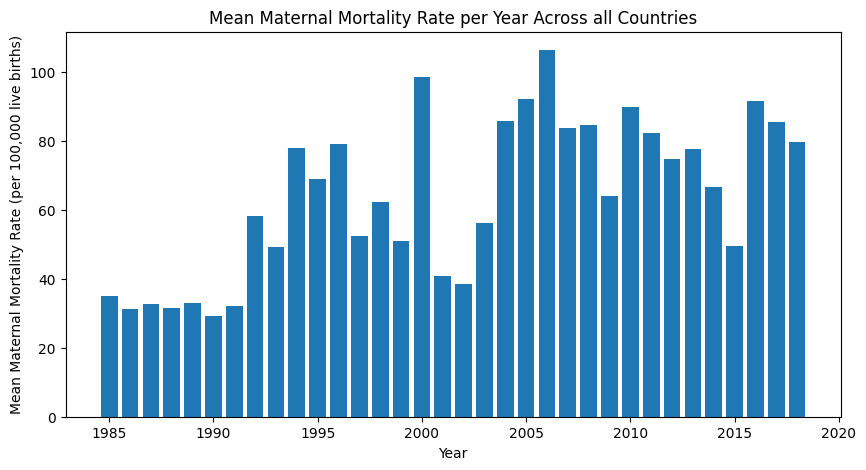

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Mean Maternal Mortality Rate per Year Across all Countries')
plt.xlabel('Year')
plt.ylabel('Mean Maternal Mortality Rate (per 100,000 live births)')
plt.bar(mean_mmr.index, mean_mmr['Maternal mortality ratio (national estimate, per 100,000 live births)'])

### PCA

In [42]:
from sklearn.impute import KNNImputer

In [43]:
merged_relevant_dropped = merged_relevant.dropna(axis=1, how='all', ignore_index=True)
merged_relevant_dropped = merged_relevant_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [44]:
merged_relevant.shape

(9018, 732)

In [46]:
m_features = merged_relevant_dropped.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)', 'date', 'setting'], axis=1)
m_features = m_features[m_features['income_num'] != 0]
merged_relevant_dropped = merged_relevant_dropped[merged_relevant_dropped['income_num'] != 0]

In [47]:
m_features.shape

(2789, 723)

In [48]:
pd.DataFrame(merged_relevant_dropped.groupby('income_num').size())

,0
income_num,
1.0,78
2.0,310
3.0,996
4.0,1405


In [49]:
knn_imputer = KNNImputer(n_neighbors=5)
m_features_senc = m_features.copy()
merged_features_imputed = knn_imputer.fit_transform(m_features_senc)

In [50]:
merged_features_imputed.shape

(2789, 723)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
m_standardised = scaler.fit_transform(merged_features_imputed)

In [52]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(m_standardised)

In [53]:
pca.explained_variance_ratio_[:10]

array([0.30796177, 0.08588423, 0.05637792, 0.03430402, 0.02731653,
       0.02333168, 0.02055609, 0.0196603 , 0.01778558, 0.01657857])

Text(0.5, 1.0, 'Percentage of Total Variance Explained (%) per Principal Component')

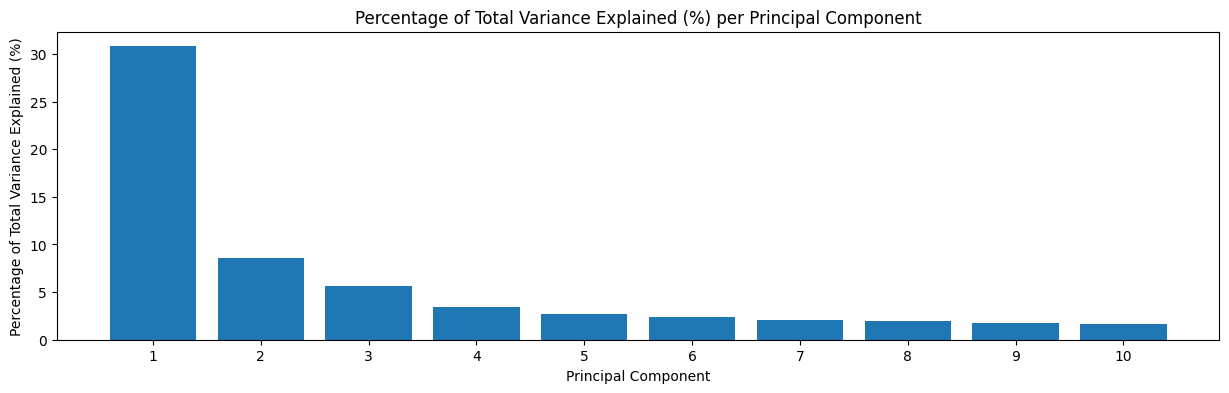

In [54]:
plt.figure(figsize=(15, 4))
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Total Variance Explained (%)')
plt.bar(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], pca.explained_variance_ratio_[:10]*100)
plt.title('Percentage of Total Variance Explained (%) per Principal Component')

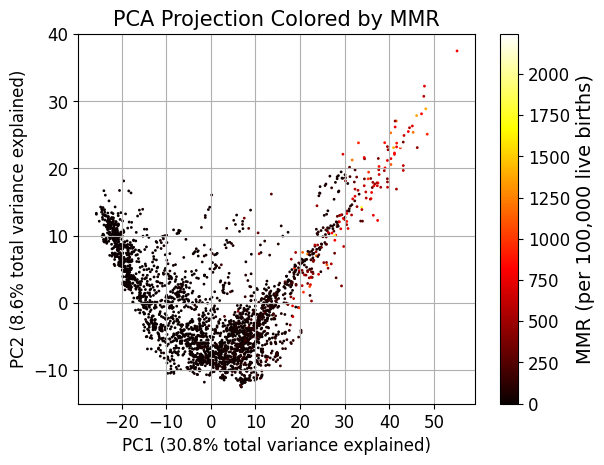

In [168]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['Maternal mortality ratio (national estimate, per 100,000 live births)'], cmap='hot', s=1)
colourbar = plt.colorbar(label='MMR (per 100,000 live births)')
colourbar.ax.tick_params(labelsize=12)
# Set colorbar axis label font size
colourbar.set_label('MMR (per 100,000 live births)', fontsize=14)
plt.title('PCA Projection Colored by MMR', fontsize=15)
plt.xlabel('PC1 (30.8% total variance explained)', fontsize=12)
plt.ylabel('PC2 (8.6% total variance explained)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [212]:
pca_data = merged_relevant_dropped.copy()

def income(num):
    if num == 1:
        return 'low'
    elif num >= 2:
        return 'lower middle'
    elif num >= 3:
        return 'upper middle'
    elif num >= 4:
        return 'high'

pca_data['income'] = pca_data['income_num'].apply(income)

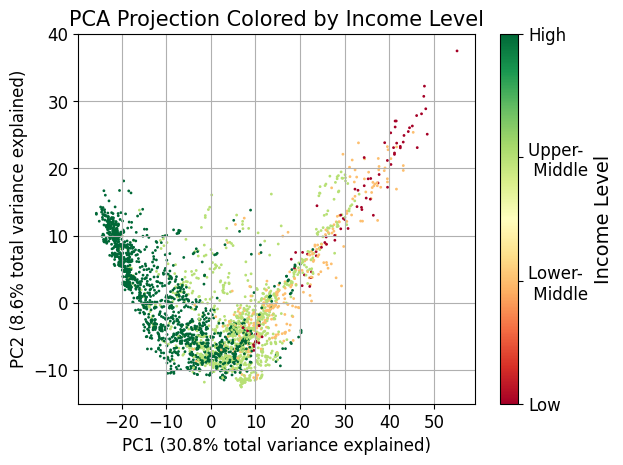

In [167]:
import matplotlib.colors as mcolors

categories = ['Low', 'Lower- \n Middle', 'Upper- \n Middle', 'High']


plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['income_num'], cmap='RdYlGn', s=1)
colourbar = plt.colorbar(label='Income Level', ticks = [1, 2, 3, 4])
colourbar.ax.tick_params(labelsize=12)
# Set colorbar axis label font size
colourbar.set_label('Income Level', fontsize=14)
colourbar.ax.set_yticklabels(categories)
plt.title('PCA Projection Colored by Income Level', fontsize=15)
plt.xlabel('PC1 (30.8% total variance explained)', fontsize=12)
plt.ylabel('PC2 (8.6% total variance explained)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

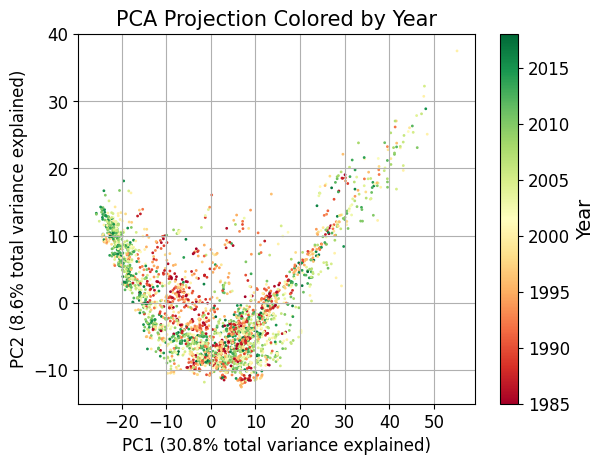

In [166]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_relevant_dropped['date'], cmap='RdYlGn', s=1)
cbar = plt.colorbar(label='Year')
cbar.ax.tick_params(labelsize=12)
# Set colorbar axis label font size
cbar.set_label('Year', fontsize=14)
plt.title('PCA Projection Colored by Year', fontsize=15)
plt.xlabel('PC1 (30.8% total variance explained)', fontsize=12)
plt.ylabel('PC2 (8.6% total variance explained)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

### Key Statistics

In [ ]:
#mmr by income level 

In [135]:
merged_relevant_dropped[merged_relevant_dropped['income_num']==4]['Maternal mortality ratio (national estimate, per 100,000 live births)'].isnull().sum()

0

In [157]:
merged_relevant_dropped.groupby('income_num')["Cause of death, by non-communicable diseases, female (% of female population)"].apply(lambda x: x.isna().sum() / (x.shape[0]))

income_num
1.0    0.807692
2.0    0.890323
3.0    0.900602
4.0    0.906050
Name: Cause of death, by non-communicable diseases, female (% of female population), dtype: float64

In [176]:
mmr_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), 
merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].std(), on='income_num')
mmr_median = pd.merge(mmr_median, merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean(), on='income_num')
mmr_median.columns = ['Median', 'Std', 'Mean']
mmr_missing = merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
mmr_median = pd.merge(mmr_median, mmr_missing, on='income_num')
mmr_median.columns = ['Maternal mortality ratio (national estimate, per 100,000 live births) Median', 'Std', 'Mean', 'Missing Data Proportion']
mmr_median

,"Maternal mortality ratio (national estimate, per 100,000 live births) Median",Std,Mean,Missing Data Proportion
income_num,,,,
1.0,617.0,452.645833,657.448718,0.0
2.0,55.5,259.860638,197.232258,0.0
3.0,38.0,55.042100,50.853414,0.0
4.0,8.0,20.852203,14.659786,0.0


In [144]:
vul_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Vulnerable employment (% of total employment) (modeled ILO estimate) female'].median(), 
merged_relevant_dropped.groupby('income_num')['Vulnerable employment (% of total employment) (modeled ILO estimate) female'].std(), on='income_num')
vul_median = pd.merge(vul_median, merged_relevant_dropped.groupby('income_num')['Vulnerable employment (% of total employment) (modeled ILO estimate) female'].mean(), on='income_num')
vul_median.columns = ['Median', 'Std', 'Mean']
vul_missing = merged_relevant_dropped.groupby('income_num')['Vulnerable employment (% of total employment) (modeled ILO estimate) female'].apply(lambda x: x.isna().sum() / (x.shape[0]))
vul_median = pd.merge(vul_median, vul_missing, on='income_num')
vul_median.columns = ['Vulnerable employment (% of total employment) (modeled ILO estimate) female Median', 'Std', 'Mean', 'Missing Data Proportion']
vul_median

,Vulnerable employment (% of total employment) (modeled ILO estimate) female Median,Std,Mean,Missing Data Proportion
income_num,,,,
1.0,89.274354,21.072974,79.575521,0.000000
2.0,48.280084,22.523910,55.323454,0.100000
3.0,32.467326,17.840445,35.578245,0.158635
4.0,8.874827,9.482425,11.940275,0.166548


In [89]:
merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median()

income_num
1.0    617.0
2.0     55.5
3.0     38.0
4.0      8.0
Name: Maternal mortality ratio (national estimate, per 100,000 live births), dtype: float64

In [88]:
merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].max() - merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].min()

income_num
1.0    2239.0
2.0    1222.0
3.0     509.0
4.0     183.0
Name: Maternal mortality ratio (national estimate, per 100,000 live births), dtype: float64

In [90]:
merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['Maternal mortality ratio (national estimate, per 100,000 live births)']

39      316.0
42      215.0
52      432.0
242     751.0
252     605.0
        ...  
7923    422.0
7927    405.0
7928    506.0
7931    286.0
7944    553.0
Name: Maternal mortality ratio (national estimate, per 100,000 live births), Length: 310, dtype: float64

In [91]:
merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].std()

income_num
1.0    452.645833
2.0    259.860638
3.0     55.042100
4.0     20.852203
Name: Maternal mortality ratio (national estimate, per 100,000 live births), dtype: float64

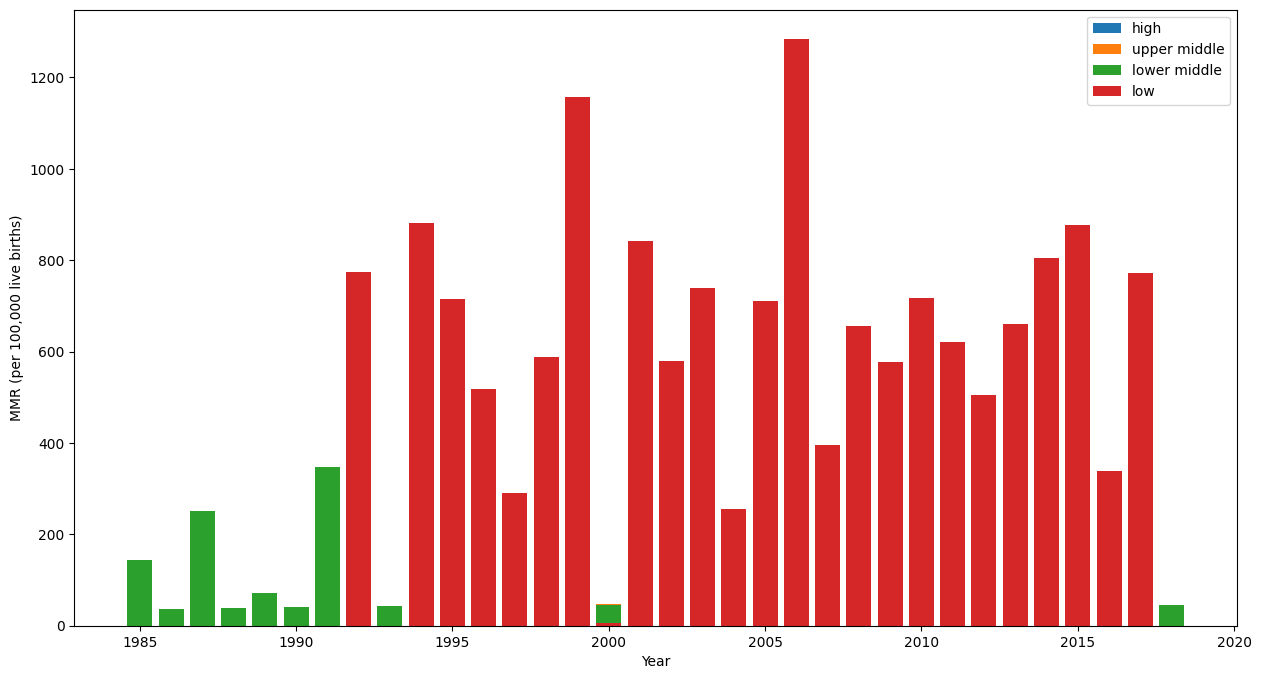

In [118]:
plt.figure(figsize=(15, 8))
plt.xlabel('Year')
plt.ylabel('MMR (per 100,000 live births)')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='low')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='lower middle')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='upper middle')
plt.bar(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 4.0]['date'].unique(), height=merged_relevant_dropped[merged_relevant_dropped['income_num'] == 4.0].groupby('date')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), label='high')
plt.bar(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0]['date'].unique(), height=merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0].groupby('date')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), label='upper middle')
plt.bar(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['date'].unique(), height=merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0].groupby('date')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), label='lower middle')
plt.bar(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0]['date'].unique(), height=merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0].groupby('date')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), label='low')
plt.legend()

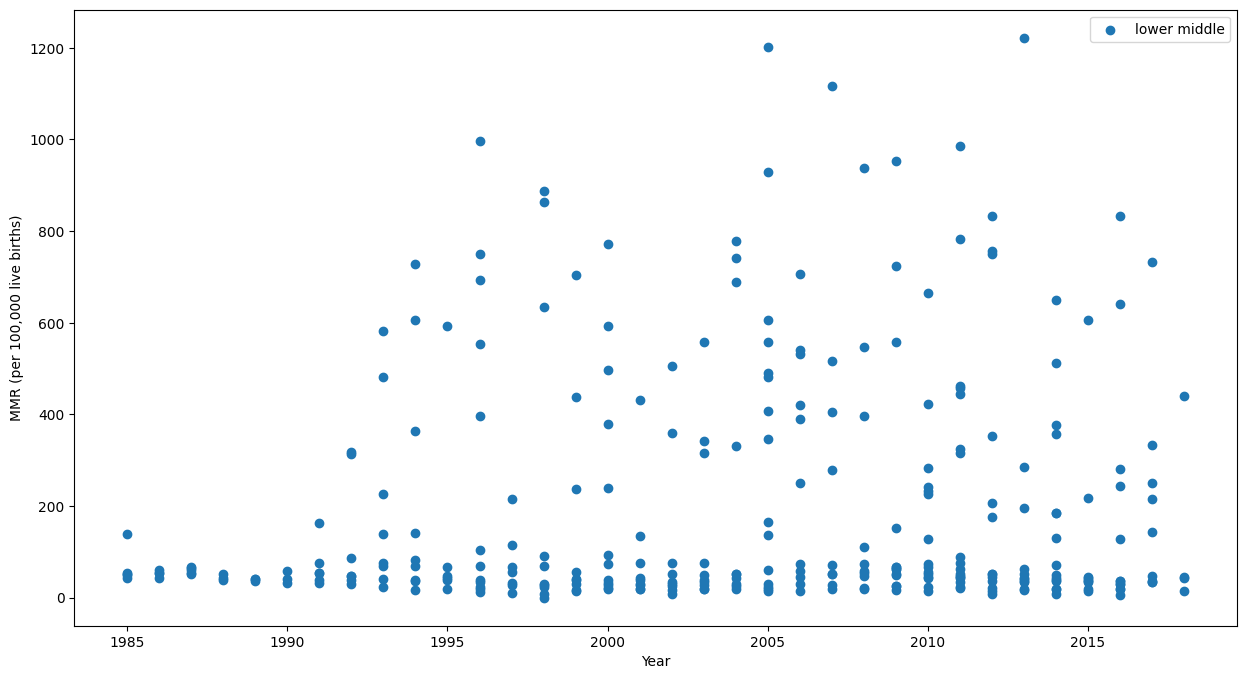

In [112]:
plt.figure(figsize=(15, 8))
plt.xlabel('Year')
plt.ylabel('MMR (per 100,000 live births)')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 1.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='low')
plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 2.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='lower middle')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 3.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='upper middle')
#plt.scatter(merged_relevant_dropped[merged_relevant_dropped['income_num'] == 4.0]['date'], merged_relevant_dropped[merged_relevant_dropped['income_num'] == 4.0]['Maternal mortality ratio (national estimate, per 100,000 live births)'], label='high')
plt.legend()

Text(0, 0.5, 'Median Maternal Mortality Ratio (per 100,000 live births)')

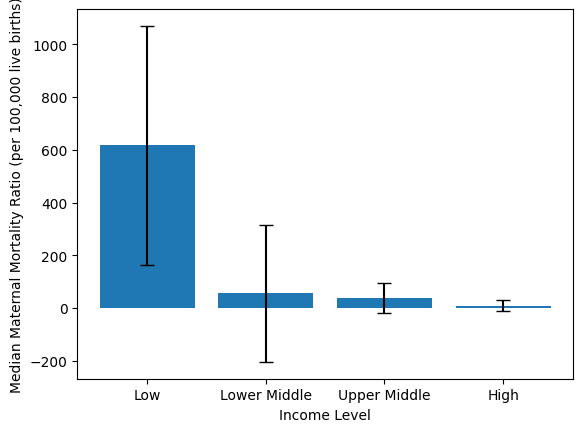

In [92]:
plt.bar(['Low', 'Lower Middle', 'Upper Middle', 'High'], height=merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].median(), yerr=merged_relevant_dropped.groupby('income_num')['Maternal mortality ratio (national estimate, per 100,000 live births)'].std(), capsize=5)
plt.xlabel('Income Level')
plt.ylabel('Median Maternal Mortality Ratio (per 100,000 live births)')

In [156]:
hiv_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Women\'s share of population ages 15+ living with HIV (%)'].median(), 
merged_relevant_dropped.groupby('income_num')["Women's share of population ages 15+ living with HIV (%)"].std(), on='income_num')
hiv_missing = merged_relevant_dropped.groupby('income_num')["Women's share of population ages 15+ living with HIV (%)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
hiv_median = pd.merge(hiv_median, hiv_missing, on='income_num')
hiv_median.columns = ["Women's share of population ages 15+ living with HIV (%) Median", 'Std', 'Missing Data Proportion']
hiv_median

,Women's share of population ages 15+ living with HIV (%) Median,Std,Missing Data Proportion
income_num,,,
1.0,58.9275,13.190321,0.000000
2.0,41.7850,16.370484,0.151613
3.0,31.0920,13.375277,0.183735
4.0,24.5475,10.383642,0.175801


In [ ]:
#income level 

In [137]:
pd.DataFrame(merged_relevant_dropped.groupby('income_num').size())

,0
income_num,
1.0,78
2.0,310
3.0,996
4.0,1405


In [226]:
pd.DataFrame(merged_relevant_dropped[merged_relevant_dropped['date']>2014].groupby('income_num').size())

,0
income_num,
1.0,7
2.0,34
3.0,70
4.0,92


In [180]:
'Women participating in own health care decisions (% of women age 15-49)'
health_decisions_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].median(), 
merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].std(), on='income_num')
health_decisions_median = pd.merge(health_decisions_median, merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].mean(), on='income_num')
health_decisions_median.columns = ['median', 'std', 'mean']
health_decisions_missing = merged_relevant_dropped.groupby('income_num')['Women participating in own health care decisions (% of women age 15-49)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
health_decisions_median = pd.merge(health_decisions_median, health_decisions_missing, on='income_num')
health_decisions_median.columns = ['Women participating in own health care decisions (% of women age 15-49) Median', 'Std', 'mean', 'Missing Data Proportion']
health_decisions_median

,Women participating in own health care decisions (% of women age 15-49) Median,Std,mean,Missing Data Proportion
income_num,,,,
1.0,59.5,21.958385,55.045455,0.576923
2.0,66.7,22.470791,65.156818,0.858065
3.0,84.1,8.740408,84.337037,0.972892
4.0,91.0,NaN,91.000000,0.999288


In [182]:
'Mortality rate, infant (per 1,000 live births)'
infant_mortality_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].median(), 
merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].std(), on='income_num')
infant_mortality_median = pd.merge(infant_mortality_median, merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].mean(), on='income_num')
infant_mortality_median.columns = ['median', 'std', 'mean']
infant_mortality_missing = merged_relevant_dropped.groupby('income_num')['Mortality rate, infant (per 1,000 live births)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
infant_mortality_median = pd.merge(infant_mortality_median, infant_mortality_missing, on='income_num')
infant_mortality_median.columns = ['Mortality rate, infant (per 1,000 live births) Median', 'Std', 'mean', 'Missing Data Proportion']
infant_mortality_median

,"Mortality rate, infant (per 1,000 live births) Median",Std,mean,Missing Data Proportion
income_num,,,,
1.0,64.80,29.358087,63.043590,0.000000
2.0,39.25,23.205178,43.040968,0.000000
3.0,19.40,15.094476,24.446586,0.000000
4.0,6.90,6.755616,8.801748,0.022776


In [183]:
'Pregnant women receiving prenatal care (%)'
prenatal_care_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].median(), 
merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].std(), on='income_num')
prenatal_care_median = pd.merge(prenatal_care_median, merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].mean(), on='income_num')
prenatal_care_median.columns = ['median', 'std', 'mean']
prenatal_care_missing = merged_relevant_dropped.groupby('income_num')['Pregnant women receiving prenatal care (%)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
prenatal_care_median = pd.merge(prenatal_care_median, prenatal_care_missing, on='income_num')
prenatal_care_median.columns = ['Pregnant women receiving prenatal care (%) Median', 'Std', 'mean', 'Missing Data Proportion']
prenatal_care_median

,Pregnant women receiving prenatal care (%) Median,Std,mean,Missing Data Proportion
income_num,,,,
1.0,84.50,23.358046,73.919643,0.282051
2.0,85.90,18.138300,81.082569,0.648387
3.0,95.80,9.702199,92.200913,0.780120
4.0,96.55,8.425194,93.268056,0.948754


In [141]:
"Stillbirth rate (per 1,000 total births)"
stillbirth_rate_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].median(), 
merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].std(), on='income_num')
stillbirth_rate_missing = merged_relevant_dropped.groupby('income_num')["Stillbirth rate (per 1,000 total births)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
stillbirth_rate_median = pd.merge(stillbirth_rate_median, stillbirth_rate_missing, on='income_num')
stillbirth_rate_median.columns = ['Stillbirth rate (per 1,000 total births) Median', 'Std', 'Missing Data Proportion']
stillbirth_rate_median

,"Stillbirth rate (per 1,000 total births) Median",Std,Missing Data Proportion
income_num,,,
1.0,22.9,6.477547,0.153846
2.0,13.3,6.419003,0.312903
3.0,9.6,4.181028,0.384538
4.0,3.3,2.609547,0.440569


In [184]:
"1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"
disease_prevalence_median = pd.merge(merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].median(), 
merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].std(), on='income_num')
disease_prevalence_median = pd.merge(disease_prevalence_median, merged_relevant_dropped.groupby('income_num')['1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female'].mean(), on='income_num')
disease_prevalence_median.columns = ['median', 'std', 'mean']
disease_prevalence_missing = merged_relevant_dropped.groupby('income_num')["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female"].apply(lambda x: x.isna().sum() / (x.shape[0]))
disease_prevalence_median = pd.merge(disease_prevalence_median, disease_prevalence_missing, on='income_num')
disease_prevalence_median.columns = ["1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female Median", 'Std', 'mean', 'Missing Data Proportion']
disease_prevalence_median

,"1.0.0 Communicable, maternal, neonatal, and nutritional diseases prevalence (age standardized) (per 100 000 population) female Median",Std,mean,Missing Data Proportion
income_num,,,,
1.0,84660.949219,14140.550603,79399.220052,0.769231
2.0,73278.921875,9389.262776,73029.855389,0.841935
3.0,63091.880859,10657.589286,62247.514562,0.863454
4.0,36806.753906,11821.396330,38835.344500,0.874021


In [185]:
"Survival to age 65, female (% of cohort)"
fem_survival_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Survival to age 65, female (% of cohort)"].median(), 
merged_relevant_dropped.groupby('income_num')["Survival to age 65, female (% of cohort)"].std(), on='income_num')
fem_survival_missing = merged_relevant_dropped.groupby('income_num')['Survival to age 65, female (% of cohort)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
fem_survival_median = pd.merge(fem_survival_median, merged_relevant_dropped.groupby('income_num')["Survival to age 65, female (% of cohort)"].mean(), on='income_num')
fem_survival_median.columns = ['median', 'std', 'mean']
fem_survival_median = pd.merge(fem_survival_median, fem_survival_missing, on='income_num')
fem_survival_median.columns = ['Survival to age 65, female (% of cohort) Median', 'Std', 'mean', 'Missing Data Proportion']
fem_survival_median

,"Survival to age 65, female (% of cohort) Median",Std,mean,Missing Data Proportion
income_num,,,,
1.0,57.5480,13.356000,58.967731,0.0
2.0,73.0700,12.235471,71.267055,0.0
3.0,80.0065,7.879657,78.694748,0.0
4.0,88.3050,5.164306,87.200213,0.0


In [144]:
"Births attended by skilled health staff (% of total)"
birth_skilled_median = pd.merge(merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].median(), 
merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].std(), on='income_num')
birth_skilled_missing = merged_relevant_dropped.groupby('income_num')["Births attended by skilled health staff (% of total)"].apply(lambda x: x.isna().sum() / (x.shape[0]))
birth_skilled_median = pd.merge(birth_skilled_median, birth_skilled_missing, on='income_num')
birth_skilled_median.columns = ['Births attended by skilled health staff (% of total) Median', 'Std', 'Missing Data Proportion']
birth_skilled_median

,Births attended by skilled health staff (% of total) Median,Std,Missing Data Proportion
income_num,,,
1.0,45.0,23.483336,0.269231
2.0,75.1,24.820573,0.422581
3.0,98.6,9.105211,0.331325
4.0,99.6,1.791267,0.385053


In [186]:
'Unmet need for contraception (% of married women ages 15-49)'
contra_need_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].median(), 
merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].std(), on='income_num')
contra_need_missing = merged_relevant_dropped.groupby('income_num')['Unmet need for contraception (% of married women ages 15-49)'].apply(lambda x: x.isna().sum() / (x.shape[0]))
contra_need_median = pd.merge(contra_need_median, merged_relevant_dropped.groupby('income_num')["Unmet need for contraception (% of married women ages 15-49)"].mean(), on='income_num')
contra_need_median.columns = ['median', 'std', 'mean']
contra_need_median = pd.merge(contra_need_median, contra_need_missing, on='income_num')
contra_need_median.columns = ['Unmet need for contraception (% of married women ages 15-49) Median', 'Std', 'mean', 'Missing Data Proportion']
contra_need_median

,Unmet need for contraception (% of married women ages 15-49) Median,Std,mean,Missing Data Proportion
income_num,,,,
1.0,27.5500,6.564645,27.122673,0.333333
2.0,22.8895,7.550450,22.454430,0.722581
3.0,12.1160,6.362408,13.391782,0.875502
4.0,10.0490,10.070294,13.372143,0.970107


In [71]:
'Wage and salaried workers (% of total employment) (modeled ILO estimate) female'
workers_median = pd.merge(merged_relevant_dropped.groupby('income_num')['Wage and salaried workers (% of total employment) (modeled ILO estimate) female'].median(), 
merged_relevant_dropped.groupby('income_num')['Wage and salaried workers (% of total employment) (modeled ILO estimate) female'].std(), on='income_num')
workers_missing = merged_relevant_dropped.groupby('income_num')['Wage and salaried workers (% of total employment) (modeled ILO estimate) female'].apply(lambda x: x.isna().sum() / (x.shape[0]))
workers_median = pd.merge(workers_median, workers_missing, on='income_num')
workers_median.columns = ['Wage and salaried workers (% of total employment) (modeled ILO estimate) female Median', 'Std', 'Missing Data Proportion']
workers_median

,Wage and salaried workers (% of total employment) (modeled ILO estimate) female Median,Std,Missing Data Proportion
income_num,,,
1.0,9.928468,20.737092,0.000000
2.0,48.798601,21.341218,0.100000
3.0,65.319313,18.191798,0.158635
4.0,89.146870,9.833676,0.166548
